In [1]:
import scipy
import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def simulate_CDDM(ub, lb, delta, ndt=0, z=0, sigma=1, dt=0.001):
    x = z
    
    rt = 0
    
    while lb(rt) < x and x < ub(rt):
        x += delta * dt + sigma*np.sqrt(dt)*np.random.normal(0, 1)
        rt += dt
        
    if x >= ub(rt):
        ch = 1
    else:
        ch = -1
        
    return (rt+ndt)*ch

In [3]:
def get_model_prediction(prms, data, model):
    RT = np.array([])
    Cont = np.array([])
    SBJ = np.array([])

    for i in tqdm(range(prms.sbj.unique().shape[0])):
        sbj = prms.sbj.unique()[i]
        
        delta0 = prms['delta0'].values[i]
        delta1 = prms['delta1'].values[i]
        t0 = prms['t0'].values[i]
        
        if model == 'exp':
            b0 = prms['b0'].values[i]
            lamda = prms['lambda'].values[i]
            ub = lambda t: b0 * np.exp(-lamda*t)
            lb = lambda t: -1*ub(t)
        elif model == 'hyp':
            b0 = prms['b0'].values[i]
            lamda = prms['lambda'].values[i]
            ub = lambda t: b0 / (1 + lamda*t)
            lb = lambda t: -1*ub(t)
        elif model == 'ddm':
            b0 = prms['b0'].values[i]
            ub = lambda t: b0
            lb = lambda t: -1*ub(t)   

        sbj_data = data[data['participant']==sbj].reset_index(drop=True)
        contrast = sbj_data.contrast.values

        rt = []

        for c in contrast:
            delta = delta0 - delta1*np.log(c)
#             delta = delta0 - delta1*np.log((c/100 - 0.025)/(c/100 + 0.025))
            rt.append(simulate_CDDM(ub, lb, delta, ndt=t0))

        RT = np.concatenate([RT, rt])
        Cont = np.concatenate([Cont, contrast])
        SBJ = np.concatenate([SBJ, np.array([sbj]*len(rt))])

    return pd.DataFrame({'sbj': SBJ,
                         'rt': np.abs(RT),
                         'accuracy': RT>0,
                         'contrast': Cont,
                         'g_contrast': Cont//10*10}) 

In [4]:
data = pd.read_csv('../../_Data/Study1.csv', 
                   index_col=0).reset_index(drop=True)

data = data.sort_values(by=['participant', 'trials', 'event'])

data = data[data.event == 3]
data['rt']/=1000
data['Duration']/=1000

data['g_contrast'] = data['contrast']//10*10

data_speed = data[data.condition == 'speed'].reset_index(drop=True)
data_accuracy = data[data.condition == 'accuracy'].reset_index(drop=True)

In [5]:
data['g_contrast'].nunique()

10

In [6]:
hyp_speed = pd.read_csv('_prms/hyp_speed.csv')
hyp_accuracy = pd.read_csv('_prms/hyp_accuracy.csv')
exp_speed = pd.read_csv('_prms/exp_speed.csv')
# exp_speed = pd.read_csv('_prms/exp_speed_log.csv')
exp_accuracy = pd.read_csv('_prms/exp_accuracy.csv')
# exp_accuracy = pd.read_csv('_prms/exp_accuracy_log.csv')
jddm_speed = pd.read_csv('_prms/jddm_speed.csv')
jddm_accuracy = pd.read_csv('_prms/jddm_accuracy.csv')
bddm_speed = pd.read_csv('_prms/bddm_speed.csv')
bddm_accuracy = pd.read_csv('_prms/bddm_accuracy.csv')

In [7]:
hyp_speed.BIC.sum(), exp_speed.BIC.sum(), jddm_speed.BIC.sum(), bddm_speed.BIC.sum()

(-33485.299569258554,
 -33410.075669493606,
 -28636.857642059498,
 4152.399678484208)

In [26]:
bddm_speed.describe()

,b0,delta0,delta1,t0,G2,BIC
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,0.612363,3.247526,0.595615,0.266152,134.470902,159.707680
std,0.085491,0.844973,0.161056,0.062237,302.624138,302.563738
min,0.500000,1.843478,0.213208,0.199347,-562.833986,-537.536550
25%,0.545095,2.758393,0.489821,0.212213,-10.901061,14.374792
50%,0.593500,3.179272,0.586902,0.251248,194.732772,220.005037
75%,0.664721,3.764002,0.708377,0.296974,351.151477,376.443522
max,0.793966,5.000000,0.890544,0.423008,595.866958,620.186691


In [8]:
hyp_accuracy.BIC.sum(), exp_accuracy.BIC.sum(), jddm_accuracy.BIC.sum(), bddm_accuracy.BIC.sum()

(-11078.958630232759,
 -10755.218472174136,
 -8632.652745820278,
 17508.068115963622)

In [30]:
bddm_accuracy.describe()

,b0,delta0,delta1,t0,G2,BIC
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,0.854814,3.449677,0.650241,0.351943,648.352924,673.387235
std,0.202434,0.836495,0.184693,0.057304,377.787707,377.782509
min,0.578695,2.011038,0.281820,0.226495,-111.764415,-86.466979
25%,0.693973,2.818526,0.575873,0.312751,346.186802,371.448234
50%,0.825550,3.501835,0.660757,0.346044,556.163210,581.442683
75%,0.992231,4.036564,0.764022,0.389892,964.027242,988.823461
max,1.464140,5.000000,1.014207,0.479865,1343.190175,1368.400651


In [9]:
pred_hyp_sp = get_model_prediction(hyp_speed, data_speed, 'hyp')
pred_hyp_ac = get_model_prediction(hyp_accuracy, data_accuracy, 'hyp')

100%|███████████████████████████████████████████| 26/26 [00:13<00:00,  1.87it/s]


In [10]:
pred_exp_sp = get_model_prediction(exp_speed, data_speed, 'exp')
pred_exp_ac = get_model_prediction(exp_accuracy, data_accuracy, 'exp')

100%|███████████████████████████████████████████| 26/26 [00:21<00:00,  1.23it/s]


In [11]:
pred_jddm_sp = get_model_prediction(jddm_speed, data_speed, 'ddm')
pred_jddm_ac = get_model_prediction(jddm_accuracy, data_accuracy, 'ddm')

100%|███████████████████████████████████████████| 26/26 [00:12<00:00,  2.10it/s]


In [12]:
pred_bddm_sp = get_model_prediction(bddm_speed, data_speed, 'ddm')
pred_bddm_ac = get_model_prediction(bddm_accuracy, data_accuracy, 'ddm')

100%|███████████████████████████████████████████| 26/26 [00:10<00:00,  2.57it/s]


In [13]:
def plot_model_pred(pred, var, color, x, label):
    err = scipy.stats.t.ppf(0.975, 26)
    temp = pred.groupby(by=['sbj', 'g_contrast'])[var].mean()
    temp = pd.DataFrame(np.array([temp[i].values for i in pred.sbj.unique()]), 
                        columns=[j*10 for j in range(10)])
    plt.errorbar(x= x + pred.groupby(by='g_contrast')['g_contrast'].mean(), 
                 y= pred.groupby(by='g_contrast')[var].mean(),
                 yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*10 for j in range(10)]]), 
                 label=label, c=color);

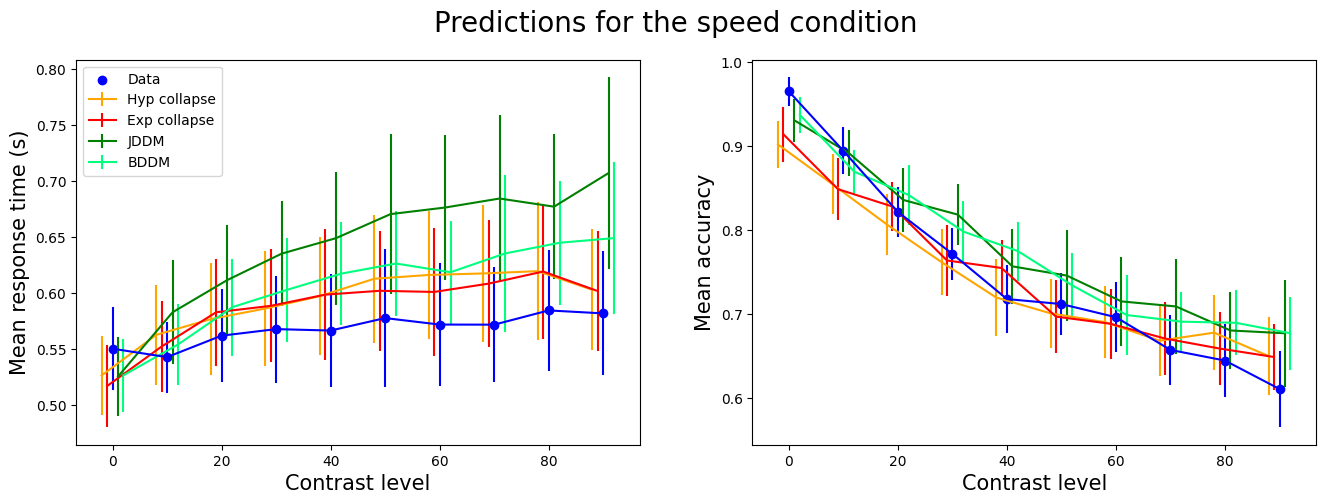

In [20]:
fig = plt.figure(figsize=(16, 5))
fig.suptitle('Predictions for the speed condition', fontsize=20)

plt.subplot(121)
plot_model_pred(pred_hyp_sp, 'rt', 'orange', -2, 'Hyp collapse')
plot_model_pred(pred_exp_sp, 'rt', 'red', -1, 'Exp collapse')
plot_model_pred(pred_jddm_sp, 'rt', 'green', 1, 'JDDM')
plot_model_pred(pred_bddm_sp, 'rt', 'springgreen', 2, 'BDDM')

err = scipy.stats.t.ppf(0.975, 26)
temp = data_speed.groupby(by=['participant', 'g_contrast'])['rt'].mean()
temp = pd.DataFrame(np.array([temp[i].values for i in data.participant.unique()]), 
                    columns=[j*10 for j in range(10)])
plt.errorbar(x=data_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=data_speed.groupby(by='g_contrast')['rt'].mean(), 
             yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*10 for j in range(10)]]), 
             c='blue');
plt.scatter(x=data_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_speed.groupby(by='g_contrast')['rt'].mean(), 
            c='blue', label='Data');
plt.xlabel('Contrast level', fontsize=15)
plt.ylabel('Mean response time (s)', fontsize=15)
plt.legend(loc='upper left');

plt.subplot(122)
plot_model_pred(pred_hyp_sp, 'accuracy', 'orange', -2, 'Hyp collapse')
plot_model_pred(pred_exp_sp, 'accuracy', 'red', -1, 'Exp collapse')
plot_model_pred(pred_jddm_sp, 'accuracy', 'green', 1, 'JDDM')
plot_model_pred(pred_bddm_sp, 'accuracy', 'springgreen', 2, 'BDDM')

temp = data_speed.groupby(by=['participant', 'g_contrast'])['correct'].mean()
temp = pd.DataFrame(np.array([temp[i].values for i in data.participant.unique()]), 
                    columns=[j*10 for j in range(10)])
plt.errorbar(x=data_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=data_speed.groupby(by='g_contrast')['correct'].mean(), 
             yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*10 for j in range(10)]]), 
             c='blue');
plt.scatter(x=data_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_speed.groupby(by='g_contrast')['correct'].mean(), 
            c='blue', label='Data');

plt.xlabel('Contrast level', fontsize=15)
plt.ylabel('Mean accuracy', fontsize=15);
# plt.legend();

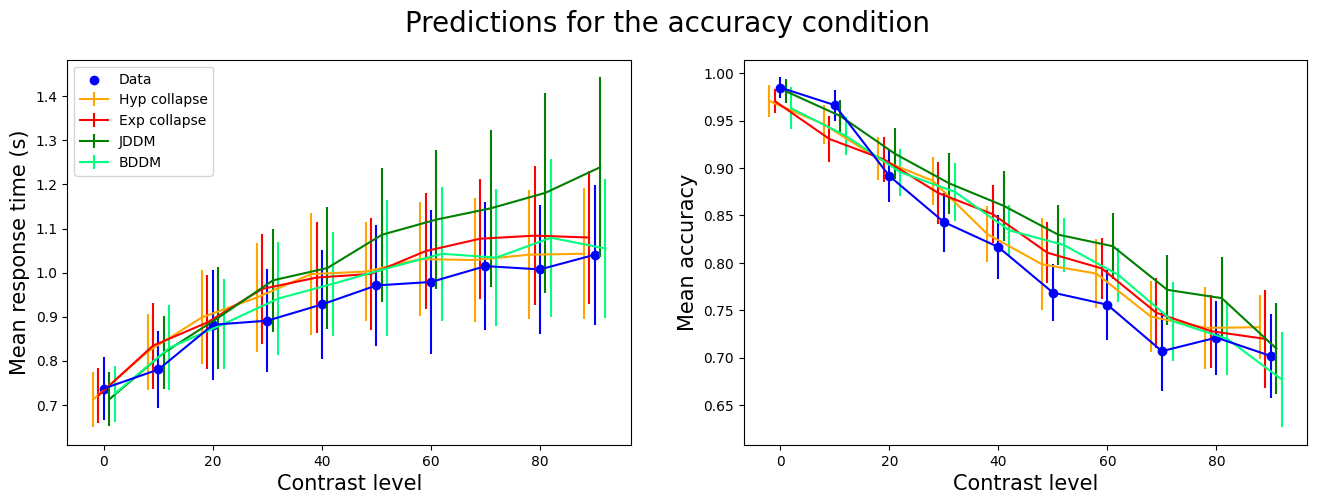

In [21]:
fig = plt.figure(figsize=(16, 5))
fig.suptitle('Predictions for the accuracy condition', fontsize=20)

plt.subplot(121)

plot_model_pred(pred_hyp_ac, 'rt', 'orange', -2, 'Hyp collapse')
plot_model_pred(pred_exp_ac, 'rt', 'red', -1, 'Exp collapse')
plot_model_pred(pred_jddm_ac, 'rt', 'green', 1, 'JDDM')
plot_model_pred(pred_bddm_ac, 'rt', 'springgreen', 2, 'BDDM')

err = scipy.stats.t.ppf(0.975, 26)
temp = data_accuracy.groupby(by=['participant', 'g_contrast'])['rt'].mean()
temp = pd.DataFrame(np.array([temp[i].values for i in data.participant.unique()]), 
                    columns=[j*10 for j in range(10)])
plt.errorbar(x=data_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=data_accuracy.groupby(by='g_contrast')['rt'].mean(), 
             yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*10 for j in range(10)]]), 
             c='blue');
plt.scatter(x=data_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_accuracy.groupby(by='g_contrast')['rt'].mean(), 
            c='blue', label='Data');
plt.xlabel('Contrast level', fontsize=15)
plt.ylabel('Mean response time (s)', fontsize=15)
plt.legend(loc='upper left');

plt.subplot(122)
plot_model_pred(pred_hyp_ac, 'accuracy', 'orange', -2, 'Hyp collapse')
plot_model_pred(pred_exp_ac, 'accuracy', 'red', -1, 'Exp collapse')
plot_model_pred(pred_jddm_ac, 'accuracy', 'green', 1, 'JDDM')
plot_model_pred(pred_bddm_ac, 'accuracy', 'springgreen', 2, 'BDDM')

temp = data_accuracy.groupby(by=['participant', 'g_contrast'])['correct'].mean()
temp = pd.DataFrame(np.array([temp[i].values for i in data.participant.unique()]), 
                    columns=[j*10 for j in range(10)])
plt.errorbar(x=data_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=data_accuracy.groupby(by='g_contrast')['correct'].mean(), 
             yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*10 for j in range(10)]]), 
             c='blue');
plt.scatter(x=data_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_accuracy.groupby(by='g_contrast')['correct'].mean(), 
            c='blue', label='Data');

plt.xlabel('Contrast level', fontsize=15)
plt.ylabel('Mean accuracy', fontsize=15);
# plt.legend();

In [12]:
data

,participant,trials,event,component,Duration,event_name,rt,condition,side,contrast,response,correct,rec_sat,rec_cont,g_contrast
0,S10_epo,0,1,0,0.019,stimulus/74,0.494141,speed,left,74,right,False,0.0,0.74,70
1,S10_epo,1,1,0,0.037,stimulus/79,0.476562,speed,left,79,right,False,0.0,0.79,75
2,S10_epo,2,1,0,0.061,stimulus/93,0.404297,speed,left,93,left,True,0.0,0.93,90
3,S10_epo,3,1,0,0.061,stimulus/50,0.337891,speed,left,50,left,True,0.0,0.50,50
4,S10_epo,4,1,0,0.021,stimulus/42,0.462891,speed,left,42,right,False,0.0,0.42,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112287,S9_epo,1111,4,0,0.048,stimulus/15,0.399414,speed,right,15,right,True,0.0,0.15,15
112288,S9_epo,1112,4,0,0.034,stimulus/81,0.366211,speed,left,81,left,True,0.0,0.81,80
112289,S9_epo,1113,4,0,0.023,stimulus/86,0.518555,speed,left,86,left,True,0.0,0.86,85
112290,S9_epo,1114,4,0,0.031,stimulus/13,0.417969,speed,right,13,right,True,0.0,0.13,10


In [18]:
data

,participant,trials,event,component,Duration,event_name,rt,condition,side,contrast,response,correct,rec_sat,rec_cont,g_contrast
56146,S10_epo,0,3,0,0.358,stimulus/74,0.494141,speed,left,74,right,False,0.0,0.74,70
56147,S10_epo,1,3,0,0.372,stimulus/79,0.476562,speed,left,79,right,False,0.0,0.79,70
56148,S10_epo,2,3,0,0.279,stimulus/93,0.404297,speed,left,93,left,True,0.0,0.93,90
56149,S10_epo,3,3,0,0.216,stimulus/50,0.337891,speed,left,50,left,True,0.0,0.50,50
56150,S10_epo,4,3,0,0.313,stimulus/42,0.462891,speed,left,42,right,False,0.0,0.42,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84214,S9_epo,1111,3,0,0.197,stimulus/15,0.399414,speed,right,15,right,True,0.0,0.15,10
84215,S9_epo,1112,3,0,0.206,stimulus/81,0.366211,speed,left,81,left,True,0.0,0.81,80
84216,S9_epo,1113,3,0,0.389,stimulus/86,0.518555,speed,left,86,left,True,0.0,0.86,80
84217,S9_epo,1114,3,0,0.208,stimulus/13,0.417969,speed,right,13,right,True,0.0,0.13,10
